In [1]:
%matplotlib inline
%matplotlib nbagg
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import bokeh
import ipywidgets
import bqplot
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import bqplot
import us
from IPython.display import display
from __future__ import print_function
import numpy as np

from bqplot import (
    Axis, ColorAxis, LinearScale, DateScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from bqplot import (
    Figure, Map, Mercator, Orthographic, ColorScale, ColorAxis,
    AlbersUSA, topo_load, Tooltip
)

In [2]:
#reads the location.txt file and provides the nescessary headers
locations=pd.read_table("C:/Users/Sayali/Desktop/Sem_1/Data_Visualisation/location.txt",names=["longitude","latitude","default1","default2"],sep="\t")

#drops  the columns which are not required in the dataset
locations.drop(["default1","default2"],inplace=True,axis=1)

In [3]:
# set a new column in location called station with 438 values
locations["station"]=np.arange(0,438)

In [4]:
#Set the index of the dataframe to 'station'
locations.set_index("station", inplace=True)
locations.head()

,longitude,latitude
station,,
0,-98.683,27.065
1,-98.102,26.938
2,-98.068,26.463
3,-117.110,32.889
4,-107.790,32.532


In [5]:
# the location co-ordinates of the tohoku earthquake is given by:
tohoku_location=(-142.4,38.3)

In [6]:
#Now, we will calculate the distance using haversine 
from haversine import haversine
locations["distance"]=[haversine(locations.loc[i],tohoku_location) for i in locations.index]
# locations.head()
# sorting all the distances from the haversine
locations=locations.sort_values("distance")
# locations.head()

In [7]:
#reading the array values into array_vals from the csv file
array_vals= pd.read_csv("C:/Users/Sayali/Desktop/Sem_1/Data_Visualisation/data_tohoku_norm_transpose.csv", header=None)

In [8]:
# Here we assume the range of 4 hours where each record has the frequency is of 1 second each.
v = pd.date_range("2:46PM", "6:46PM", freq="1s")
v -= v[0]
array_vals["time"] = v
# setting time as the index 
array_vals.set_index("time", inplace=True)

In [9]:
# Here, we try to use Normalization to find the min and max values 
min_val=array_vals.min().min()
max_val=array_vals.max().max()
norm_array_vals=(array_vals-min_val)/(max_val-min_val)
#here we replace the missing of NaN values with the mean value 
avg_array_val=norm_array_vals.mean()
norm_array_vals= norm_array_vals.fillna((avg_array_val[49]+avg_array_val[50] )/2)


In [10]:
# Funtion to plot a spectogram for the tohoku earthquake
def make_spect():
    fig, ax = plt.subplots()
    plt.imshow(array_vals.transpose(), aspect = 'auto', cmap = 'viridis',vmin=0, vmax=1)
    plt.colorbar(label="MAGNITUDE OF THE TOHOKU EARTHQUAKE")
    plt.xlabel('TIME IN SECONDS')
    plt.ylabel('DETECTOR OF THE EARTHQUAKE')
    ann = ax.annotate("", xy=(0,0),xytext=(0,18),textcoords="offset points",
                        bbox=dict(boxstyle="square", fc="w"))
    ann.set_visible(False)
# function user to create the hover event
    def hover(event):
        if event.xdata<(ax.get_xlim()[1]-ax.get_xlim()[0])/2:
            ann.xy=(event.xdata+100,event.ydata)  
        else:
            ann.xy=(event.xdata-3000,event.ydata)
        ann.set_text("detector#=%s\ntime=%ss" %(locations.index.values[int(event.ydata)], int(event.xdata)))   
        ann.set_visible(True)

    cid = fig.canvas.mpl_connect('motion_notify_event', hover)

In [11]:
# creating the waveform
def wave_form_detect(station, time):
    x = range(0, time)
    y = array_vals.iloc[:time][station]
    return x, y
# updating the waveform 
def update_wave(self, target):
    #print(sel_station)
    new_x, new_y = wave_form_detect(scat_plot.selected, slider.value)
    wave.x = new_x
    wave.y = new_y
# defining color based on time 
def get_col(time): 
    temp = np.array(norm_array_vals.iloc[time].values.flatten())
    c_map = np.log10(np.nan_to_num(temp))
    return c_map
# updating the detector colors
def upd_col_lat(change):
    scat_plot.color=get_col(slider.value)
    
    
    
def upd_wf_title(self, target):
    waveform.title = 'WAVEFORM OF STATION' + str(scat_plot.selected) + 'FOR THE TIME PERIOD' + str(slider.value)
    
    
def upd_time_wf(change):
    waveform.title = 'WAVEFORM OF STATION' + str(scat_plot.selected) + 'FOR THE TIME PERIOD' + str(slider.value)

In [12]:
# time slider for the 4 hours that we assumed with a difference in 1 second from each observation

time = pd.Series(range(0,array_vals[0].size))
slider =  widgets.IntSlider(min=time.min()+1, max=time.max()+1, value=1, description='TIME IN SECONDS')


In [13]:
# Creating a map
sc_geo = AlbersUSA()
sc_geo.scale_factor=1090
states_map = Map(map_data=topo_load('map_data/USStatesMap.json'), scales={'projection': sc_geo},hovered_styles={'hovered_fill':None})

# states_map.hover_highlight=False


In [14]:
# setting the scales for the scatter plots
sc_x = LinearScale(min=25, max=50)
sc_y = LinearScale(min=-115, max=-80)
col_sc = ColorScale()
color = get_col(slider.value)
scat_plot = Scatter(x=locations['latitude'] , y=locations['longitude'], 
                scales={'x': sc_x, 'y': sc_y, 'color': col_sc},                
                color=color,
                stroke='blue',
                interactions={'click': 'select'},
                selected_style={'opacity': 1.5, 'fill': 'pink', 'stroke': 'yellow'},
                unselected_style={'opacity': 1.0})

ax_c = ColorAxis(scale=col_sc, label='INTENSITY',side='left',tick_format='0.3f')

detector_loc = Figure(marks=[states_map,scat_plot],axes=[ax_c], title='DETECTOR LOCATION')



In [15]:
# setting the scales of the waveform
x = LinearScale()
y = LinearScale(min=-1.7, max=1.7)

 

try:
    ani_time = int(slider.value/10)
except TypeError:
    ani_time = 500


### Create a line plot using the X and Y values. 

wave = Lines(scales={'x': x, 'y': y}, colors=['green'],
               enable_move=False)

ax_x = Axis(scale=x, tick_format='0.f', label = 'TIME IN SECONDS')
ax_y = Axis(scale=y, tick_format='0.3f', label = 'MAGNITUDE OF THE EARTHQUAKE', orientation='vertical')

waveform = Figure(marks=[wave], axes=[ax_x, ax_y], 
                title='WAVEFORM:',
                animation_duration=ani_time)

# Calculate the waveform for the station for default values...
initial_station = np.random.randint(0,len(locations))
initial_timeinterval=1500

wave.x, wave.y = wave_form_detect(initial_station, initial_timeinterval)
waveform.title = 'WAVEFORM OF THE STATION: ' + str(initial_station) + ' FOR THE TIME PERIOD: ' + str(initial_timeinterval)
# waveform

In [16]:
# Function calls for the callbacks. 
scat_plot.on_element_click(update_wave)
scat_plot.on_element_click(upd_wf_title) 
slider.observe(upd_col_lat, names='value')
slider.observe(upd_time_wf, names='value')

In [17]:
# Creating a time slider for the 4 hours
time = pd.Series(range(0,array_vals[0].size))
#slider = interactive(get_time, interval=(time.min()+1, time.max()+1, 1))
slider =  widgets.IntSlider(min=time.min()+1, max=time.max()+1, value=1, description='TIME PERIOD')
# display(slider)

<IPython.core.display.Javascript object>


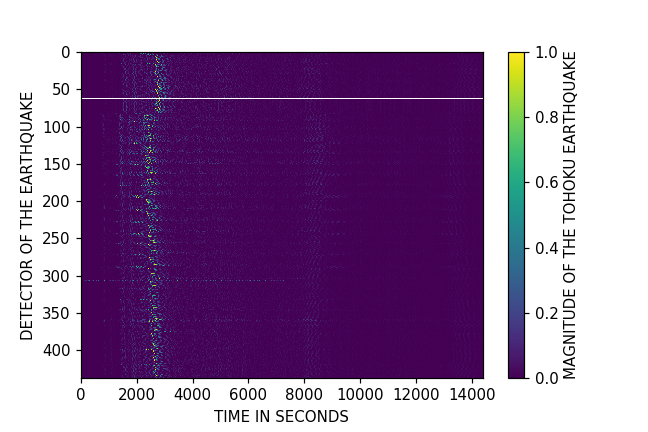

IntSlider(value=1, description='TIME PERIOD', max=14401, min=1)

HBox(children=(Figure(axes=[ColorAxis(label='INTENSITY', scale=ColorScale(), side='left', tick_format='0.3f')], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Map(hovered_styles={'hovered_fill': None}, interactions={'hover': 'tooltip'}, map_data={'type': 'Topology', 'objects': {'land': {'type': 'MultiPolygon', 'properties': {'counties': None}, 'arcs': [[[5830, 6026, 6034, 6073, 6164, 6179, 6023, 6043, 6231, 6416, 6410, 6564, 6243, 6565, 6546, 6475, 6542, 6784, 6741, 6811, 6739, 6870, 6965, 7087, 7246, -7086, 7247, 7255, 7256, 7257, 7305, 7566, 9399, 7668, 9397, -7836, 9398, 7838, 8050, 8017, 8018, 8019, 8020, 8021, 8047, 8023, 8252, 8247, 8302, 8493, 8575, -8491, 8576, 8671, 8807, 8877, 8984, 9074, 9116, 9138, 9129, 9073, 8960, 8874, 8961, 8956, 8957, 9090, 9130, 9181, -9123, 9182, 9125, 9177, 9255, 9278, 9279, 9280, 9311, 9306, 9307, 9308, 9309, 9318, 9340, 9347, 9342, 9343, 9344, 9345, 9349, 9338, 9326, 9317, 9284, 9315, 9286, 9266, 9241, 9239, 9214, 9200, 9170, 9113, 9114, 9350, 8936, 8837, 8937, 9039, 8977, 9038, 8979, 8884, 8980, 8886, 8777, -8768, 8778, 8770, 8761, 8755, 8642, 8643, 8644, 8667, 8810, 8833, 8851, 8819, 8981, 9002, 8999, 9000, 9064, 8974, 9059, -8971, 9053, 9054, 9055, 9056, 9057, 9083, 9044, 9023, 9011, 9034, 8988, 9065, 9108, 9067, 8991, 9107, 9109, 9152, 9193, 9141, 9196, 9143, 9144, 9145, 9156, 9195, 9206, 9226, 9190, 9227, 9208, 9222, 9232, 9225, 9233, 9234, 9235, 9252, 9273, 9303, 9334, 9339, 9331, 9328, 9292, 9231, 9167, 9104, 8944, 8844, 8841, 8854, 8358, 8360, 7864, 8080, 8008, 8177, 8470, 8160, 7700, 7715, 7672, 7495, 7030, 6995, 6876, 6510, 5861, 5585, 5267, 5171, 5264, 5415, 5133, 4992, 4822, 4518, 4663, 4437, 4662, 4439, 4447, 4816, 4449, 3587, 2648, 2337, 1859, 1579, 1433, 1268, 954, 753, 600, 639, 586, 588, 454, 330, 221, 175, 222, 306, 264, 358, 261, 359, 308, 394, 357, 294, 184, 172, 185, 126, 2, 73, 83, 78, 81, 22, 34, 18, 41, 97, 86, 44, 48, 27, 8, 51, 108, 91, 96, 101, 38, 30, 62, 66, 55, 58, 104, 9351, 123, 139, 192, 9352, 191, 134, 9354, 9356, 9357, 541, 465, 421, 9362, 433, 9366, 9368, 472, 9377, 9374, 9375, 9379, 554, 9369, 690, 9370, 854, 855, 856, 1128, 1140, 9371, 1138, 1259, 1443, 1591, 1767, 1926, 1992, 2081, 2199, 2497, 2499, 2431, 2170, 2116, 1954, 1753, 1654, 1502, 1348, 1197, 1085, 9386, 9387, 922, 9382, 9381, 748, 797, 9388, 1048, 1208, 9389, 1403, 1529, 9390, 1546, 9391, 1893, 9392, 9396, 2469, 2470, 2471, 2472, 2473, 2478, 2479, 2480, 2632, 2558, 2599, 2544, 2407, 2365, 2166, 2027, 1797, 1684, 1681, 1689, 1692, 1669, 1538, 1249, 1250, 1251, 993, 1005, 979, 975, 968, 982, 972, 874, 865, 794, 547, 347, 790, 894, 577, 1090, 1252, 1256, 1360, 1258, 1107, 1361, 1350, 1359, 1352, 1506, 1583, 1715, 1900, 2085, 1971, 1972, 1973, 2083, 2132, 2143, 2130, 2139, 2252, 2141, 2213, 2509, 2215, 2416, 2285, 2418, 2517, 2491, 2523, 2525, -2522, 2526, 2511, 2715, 3009, 3060, 3011, 2714, 2592, 2733, 2860, 3079, 3029, 3120, 3220, 3309, 3493, 3483, 3769, 4090, 3909, 3748, 3907, 3751, 3713, 3752, 3715, 3753, 3687, 3629, 3486, 3515, 3546, 3717, 4068, 4359, 4360, 4361, 4754, 5037, 5382, 5036, 4752, 4833, 4656, 4547, 4233, 4375, 4135, 4044, 3788, 3798, 3804, 4054, 4158, -4053, 4159, 4488, 4258, 4579, 4696, 4581, 4260, 4352, 4385, 4467, 4307, 4376, 4635, 4780, 4842, 5041, 5166, 4979, 4841, 4777, 4956, 5203, 5347, 5401, 5349, 5086, 5126, 5306, 5451, 5514, 5635, 5663, 5616, 5450, 5408, 5260, 5371, 5555, 5560, 5604, 5646, 5858, 5854, 5890, 5851, 5802, 5891, 5833, 5804, 5834, 6027, 6244, 6029, 5828, 5829], [-5826, -5827]], [[116]], [[117]], [[118]], [[173]], [[259]], [[291]], [[892]], [[893]], [[9360, 9363]], [[9361]], [[9372]], [[9373]], [[9378]], [[9383]], [[9384]], [[9358]], [[1793]], [[3017, 3084, 3116, 3086, 3019, 2745, 3015, 3016]], [[-3083, 3082, 9861]], [[3201]], [[2595]], [[2690]], [[2508]], [[6873]], [[6874]], [[6994]], [[7027]], [[7028]], [[4132]], [[4828, 4829, 4827]], [[4832, 4830, 4831]], [[6241, 6240]], [[9105]], [[9192, 9191]], 

In [18]:
# spectogram 
make_spect()
# sliders 
display(slider)
# waveform and detector 
plots = widgets.HBox(children=[detector_loc,waveform])
plots